In [2]:
# to install r packages
#install.packages("magick", repos='http://cran.us.r-project.org')
library(dplyr)
library(tidyverse)
library(plotly)

Warning message:
"package 'dplyr' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'tidyverse' was built under R version 3.6.3"-- Attaching packages --------------------------------------- tidyverse 1.3.0 --
v ggplot2 3.2.1     v purrr   0.3.4
v tibble  2.1.3     v stringr 1.4.0
v tidyr   1.1.2     v forcats 0.4.0
v readr   1.3.1     
Warning message:
"package 'tidyr' was built under R version 3.6.3"Warning message:
"package 'purrr' was built under R version 3.6.3"-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Warning message:
"package 'plotly' was built under R version 3.6.2"
Attaching package: 'plotly'

The following object is masked from 'package:ggplot2':

    last_plot

In [67]:
# Input Tables: 
#   1/ body mass at age Ford et al. 2010, pp. 22, Table 6
#   2/ NRKW & SRKW life tables (demographics) from Ford et al. (2010, pp. 22-23, Table 7-8) 2008 census 
#   3/ TKW pop'n time series 1974-2006 Ford et al., 2007; p 9, Fig 7 some is reported 
#     in text, the rest is digitized from figure
#
# Equations: 
#   Length-weight equation published in Bigg & Wolman, 1975: L = (W - 0.000208)^(1/2.577)
#   Daily consumption (kg / day) published in Kriete (1995): Q = 0.277 * M^0.663

localpath = "C:\\Users\\Greig\\Sync\\6. SSMSP Model\\Model Greig\\Data\\15. Killer Whale\\"

# "Fordetal2010_Table6_BodyMass.csv"
# "Fordetal2010_Table7and8_SRKW_NRKW_demog.csv"
# "Fordetal2007_p9_fig7_TKW_abun.csv"
mass_age <- read.csv(paste(localpath,"Fordetal2010_Table6_BodyMass.csv",sep=""))
demog <- read.csv(paste(localpath,"Fordetal2010_Table7and8_SRKW_NRKW_demog.csv",sep=""))
abun <- read.csv(paste(localpath,"Fordetal2007_p9_fig7_TKW_abun.csv",sep=""))

####################### PARAMS ######################
# ratio of transient length to resident length
TKW_RKW_length_ratio = 1.11
# square km study area
study_area_km2 = 11274 # may 16 based on arcmap analysis
# estimates of proportion parent pop foraging in area
initial_prop_vist_area_min = .3
initial_prop_vist_area_mid = .5
initial_prop_vist_area_max = .7
end_prop_vist_area_min = .7
end_prop_vist_area_mid = .8
end_prop_vist_area_max = .9
# estimates of proportion of year spent in area
initial_prop_forage_min = .25
initial_prop_forage_mid = .29
initial_prop_forage_max = .33
end_prop_forage_min = .33
end_prop_forage_mid = .44
end_prop_forage_max = .5
#####################################################

main_table = demog %>% 
left_join(mass_age, by = c("Age..and.Sex.Class" = "Age..and.Sex.Class")) %>%
mutate(NRKW_mass_2008 = NRKW.N.2008 * Body.Mass..kg.) %>%
mutate(SRKW_mass_2008 = SRKW.N.2008 * Body.Mass..kg.) %>%
rename(NRKW_2008_perc = NRKW.2008.pop..) %>%
rename(SRKW_2008_perc = SRKW.2008.pop..) %>%
rename(body_mass_kg = Body.Mass..kg.) %>%
rename(age_sex_class = Age..and.Sex.Class) %>%
rename(SRKW_N_2008 = SRKW.N.2008) %>%
rename(NRKW_N_2008 = NRKW.N.2008) %>%
mutate(length_SRKW_NRKW = (body_mass_kg/0.000208)^(1/2.577)) %>%
mutate(length_TKW = length_SRKW_NRKW * TKW_RKW_length_ratio) %>%
mutate(mass_age_TKW = 0.000208*length_TKW^2.577)

# calculate biomass of pop'n based on life tables, l-w relationship, TKW:RKW length est
abun$biomass_mt_min=0
abun$biomass_mt_mid=0
abun$biomass_mt_max=0
abun$consump_mt_yr_min=0
abun$consump_mt_yr_mid=0
abun$consump_mt_yr_max=0

annual_avg_indiv_mass <- data.frame(year=abun['abun_min'][1,], avg_TKW_indiv_B_1_min=0, avg_TKW_indiv_B_2_min=0,
                                    avg_TKW_indiv_B_1_mid=0, avg_TKW_indiv_B_2_mid=0,
                                    avg_TKW_indiv_B_1_max=0, avg_TKW_indiv_B_2_max=0
                                   )

for(i in 1:length(abun[1][,])) {
    if (!is.na(abun['abun_min'][i,])) {
        temp_table = main_table %>% 
            mutate(abun_TKW_min_1 = abun['abun_min'][i,] * (SRKW_2008_perc / 100)) %>%
            mutate(abun_TKW_min_2 = abun['abun_min'][i,] * (NRKW_2008_perc / 100)) %>%
            mutate(total_mass_age_min_1 = abun_TKW_min_1 * mass_age_TKW) %>%
            mutate(total_mass_age_min_2 = abun_TKW_min_2 * mass_age_TKW) %>% 
            mutate(abun_TKW_mid_1 = abun['abun_mid'][i,] * (SRKW_2008_perc / 100)) %>%
            mutate(abun_TKW_mid_2 = abun['abun_mid'][i,] * (NRKW_2008_perc / 100)) %>%
            mutate(total_mass_age_mid_1 = abun_TKW_mid_1 * mass_age_TKW) %>%
            mutate(total_mass_age_mid_2 = abun_TKW_mid_2 * mass_age_TKW) %>% 
            mutate(abun_TKW_max_1 = abun['abun_max'][i,] * (SRKW_2008_perc / 100)) %>%
            mutate(abun_TKW_max_2 = abun['abun_max'][i,] * (NRKW_2008_perc / 100)) %>%
            mutate(total_mass_age_max_1 = abun_TKW_max_1 * mass_age_TKW) %>%
            mutate(total_mass_age_max_2 = abun_TKW_max_2 * mass_age_TKW)  %>%
            mutate(daily_consumption_kg_min_1 = (0.277 * mass_age_TKW^0.663)*abun_TKW_min_1) %>%
            mutate(daily_consumption_kg_min_2 = (0.277 * mass_age_TKW^0.663)*abun_TKW_min_2) %>%
            mutate(daily_consumption_kg_mid_1 = (0.277 * mass_age_TKW^0.663)*abun_TKW_mid_1) %>%
            mutate(daily_consumption_kg_mid_2 = (0.277 * mass_age_TKW^0.663)*abun_TKW_mid_2) %>%
            mutate(daily_consumption_kg_max_1 = (0.277 * mass_age_TKW^0.663)*abun_TKW_max_1) %>%
            mutate(daily_consumption_kg_max_2 = (0.277 * mass_age_TKW^0.663)*abun_TKW_max_2)

        total_tkw_biomass_mt_min_1 = sum(temp_table[, 'total_mass_age_min_1']) / 1000
        total_tkw_biomass_mt_min_2 = sum(temp_table[, 'total_mass_age_min_2']) / 1000
        total_tkw_biomass_mt_mid_1 = sum(temp_table[, 'total_mass_age_mid_1']) / 1000
        total_tkw_biomass_mt_mid_2 = sum(temp_table[, 'total_mass_age_mid_2']) / 1000
        total_tkw_biomass_mt_max_1 = sum(temp_table[, 'total_mass_age_max_1']) / 1000
        total_tkw_biomass_mt_max_2 = sum(temp_table[, 'total_mass_age_max_2']) / 1000
                   
        total_tkw_consumption_kg_min_1 = sum(temp_table[, 'daily_consumption_kg_min_1'])
        total_tkw_consumption_kg_min_2 = sum(temp_table[, 'daily_consumption_kg_min_2'])
        total_tkw_consumption_kg_mid_1 = sum(temp_table[, 'daily_consumption_kg_mid_1'])
        total_tkw_consumption_kg_mid_2 = sum(temp_table[, 'daily_consumption_kg_mid_2'])
        total_tkw_consumption_kg_max_1 = sum(temp_table[, 'daily_consumption_kg_max_1'])
        total_tkw_consumption_kg_max_2 = sum(temp_table[, 'daily_consumption_kg_max_2'])

        avg_TKW_indiv_B_1_min = total_tkw_biomass_mt_min_1 / abun['abun_min'][i,]
        avg_TKW_indiv_B_2_min = total_tkw_biomass_mt_min_2 / abun['abun_min'][i,]
        avg_TKW_indiv_B_1_mid = total_tkw_biomass_mt_mid_1 / abun['abun_mid'][i,]
        avg_TKW_indiv_B_2_mid = total_tkw_biomass_mt_mid_2 / abun['abun_mid'][i,]
        avg_TKW_indiv_B_1_max = total_tkw_biomass_mt_max_1 / abun['abun_max'][i,]
        avg_TKW_indiv_B_2_max = total_tkw_biomass_mt_max_2 / abun['abun_max'][i,]
        
        temp_avg_indiv_mass = data.frame(year=abun['year'][i,],
                                         avg_TKW_indiv_B_1_min=avg_TKW_indiv_B_1_min,
                                         avg_TKW_indiv_B_2_min=avg_TKW_indiv_B_2_min,
                                         avg_TKW_indiv_B_1_mid=avg_TKW_indiv_B_1_mid,
                                         avg_TKW_indiv_B_2_mid=avg_TKW_indiv_B_2_mid,
                                         avg_TKW_indiv_B_1_max=avg_TKW_indiv_B_1_max,
                                         avg_TKW_indiv_B_2_max=avg_TKW_indiv_B_2_max)
        
        annual_avg_indiv_mass = rbind(annual_avg_indiv_mass, temp_avg_indiv_mass)   
        
        # biomass estimates
        if(total_tkw_biomass_mt_min_1 < total_tkw_biomass_mt_min_2){
            total_tkw_biomass_min = total_tkw_biomass_mt_min_1
        }else{
            total_tkw_biomass_min = total_tkw_biomass_mt_min_2
        }
        
        total_tkw_biomass_mid = (total_tkw_biomass_mt_mid_1 + total_tkw_biomass_mt_mid_2) / 2
        
        if(total_tkw_biomass_mt_max_1 > total_tkw_biomass_mt_max_2){
            total_tkw_biomass_max = total_tkw_biomass_mt_max_1
        }else{
            total_tkw_biomass_max = total_tkw_biomass_mt_max_2
        }
        
        # consumption calcs (find the min and max estimates etc)
        if(total_tkw_consumption_kg_min_1 < total_tkw_consumption_kg_min_2){
            total_tkw_consumption_kg_min = total_tkw_consumption_kg_min_1
        }else{
            total_tkw_consumption_kg_min = total_tkw_consumption_kg_min_2
        }
        total_tkw_consumption_kg_mid = (total_tkw_consumption_kg_mid_1 + total_tkw_consumption_kg_mid_2) / 2
        if(total_tkw_consumption_kg_max_1 > total_tkw_consumption_kg_max_2){
            total_tkw_consumption_kg_max = total_tkw_consumption_kg_max_1
        }else{
            total_tkw_consumption_kg_max = total_tkw_consumption_kg_max_2
        }
    }
    abun['biomass_mt_min'][i,] = total_tkw_biomass_min
    abun['biomass_mt_mid'][i,] = total_tkw_biomass_mid
    abun['biomass_mt_max'][i,] = total_tkw_biomass_max         
                   
    abun['consump_mt_yr_min'][i,] = total_tkw_consumption_kg_min / 1000 * 365
    abun['consump_mt_yr_mid'][i,] = total_tkw_consumption_kg_mid / 1000 * 365
    abun['consump_mt_yr_max'][i,] = total_tkw_consumption_kg_max / 1000 * 365                 
                   
}

# sigmoid function growing prop pop and prop time foraging
abun_expanded <- data.frame(abun)

# fill in subsequent years
j = 0
for(i in 2007:2019){
  abun_expanded[1][34+j,] = i
  j = j + 1
}
abun_expanded$gen_sig_time = 0 # generic sigmoid t = time step placeholder

#populate the generic sig eqn time cole so min year = -5 and max year = +5
# initialize
abun_expanded['gen_sig_time'][1,] = -5
for(i in 2:length(abun_expanded[1][,])) {
    # I pre-calculated to get 0.222 for 1974 - 2019
    # todo: calc on-the-fly
    abun_expanded['gen_sig_time'][i,] = abun_expanded['gen_sig_time'][i-1,]+0.222 
}

# generic sigmoid equation value for each time step b/w -5 -> 5
# =1/(1+2.71828^(t*-1))
abun_expanded = abun_expanded %>% mutate(gen_sig_eqn_val = 1/(1+2.71828^(gen_sig_time*-1)))

###### Set up the proportion visiting and prop foraging estimates ##########
######    - assuming a model of sigmoidal growth since 1974  ##########

# proportion of 'parent' TKW pop accessing area
abun_expanded$prop_visit_area_min = 0
abun_expanded$prop_visit_area_mid = 0 
abun_expanded$prop_visit_area_max = 0 

# prop of year visiting whales spent in area
abun_expanded$prop_forage_min = 0
abun_expanded$prop_forage_mid = 0 
abun_expanded$prop_forage_max = 0

abun_expanded['prop_visit_area_min'][1,] = initial_prop_vist_area_min
abun_expanded['prop_visit_area_mid'][1,] = initial_prop_vist_area_mid
abun_expanded['prop_visit_area_max'][1,] = initial_prop_vist_area_max

abun_expanded['prop_forage_min'][1,] = initial_prop_forage_min
abun_expanded['prop_forage_mid'][1,] = initial_prop_forage_mid
abun_expanded['prop_forage_max'][1,] = initial_prop_forage_max

last_row = length(abun_expanded[1][,])

abun_expanded['prop_visit_area_min'][last_row,] = end_prop_vist_area_min
abun_expanded['prop_visit_area_mid'][last_row,] = end_prop_vist_area_mid
abun_expanded['prop_visit_area_max'][last_row,] = end_prop_vist_area_max

abun_expanded['prop_forage_min'][last_row,] = end_prop_forage_min
abun_expanded['prop_forage_mid'][last_row,] = end_prop_forage_mid
abun_expanded['prop_forage_max'][last_row,] = end_prop_forage_max

# interpolate between base year and end year using sigmoidal values
# =startyearvalue+(sigfunctionvalue*(endyearvalue-startyearvalue))
# using loop b/c I want to 'mask out' the first and last rows
for(i in 2:(length(abun_expanded[1][,])-1)) {
    abun_expanded['prop_visit_area_min'][i,] = initial_prop_vist_area_min + 
                                               (abun_expanded['gen_sig_eqn_val'][i,] *
                                               (end_prop_vist_area_min - initial_prop_vist_area_min))
    abun_expanded['prop_visit_area_mid'][i,] = initial_prop_vist_area_mid + 
                                               (abun_expanded['gen_sig_eqn_val'][i,] *
                                               (end_prop_vist_area_mid - initial_prop_vist_area_mid)) 
    abun_expanded['prop_visit_area_max'][i,] = initial_prop_vist_area_max + 
                                               (abun_expanded['gen_sig_eqn_val'][i,] *
                                               (end_prop_vist_area_max - initial_prop_vist_area_max))
    abun_expanded['prop_forage_min'][i,] = initial_prop_forage_min + 
                                               (abun_expanded['gen_sig_eqn_val'][i,] *
                                               (end_prop_forage_min - initial_prop_forage_min))
    abun_expanded['prop_forage_mid'][i,] = initial_prop_forage_mid + 
                                               (abun_expanded['gen_sig_eqn_val'][i,] *
                                               (end_prop_forage_mid - initial_prop_forage_mid))
    abun_expanded['prop_forage_max'][i,] = initial_prop_forage_max + 
                                               (abun_expanded['gen_sig_eqn_val'][i,] *
                                               (end_prop_forage_max - initial_prop_forage_max))  
}

abun_expanded = abun_expanded %>% 
mutate(total_B_min = biomass_mt_min * prop_visit_area_min * prop_forage_min) %>%
mutate(total_B_mid = biomass_mt_mid * prop_visit_area_mid * prop_forage_mid) %>%
mutate(total_B_max = biomass_mt_max * prop_visit_area_max * prop_forage_max) %>%
mutate(total_B_dens_min = total_B_min / study_area_km2) %>% # B density mt / sq km
mutate(total_B_dens_mid = total_B_mid / study_area_km2) %>% 
mutate(total_B_dens_max = total_B_max / study_area_km2) %>%
mutate(QB_min = consump_mt_yr_min / biomass_mt_min) %>%
mutate(QB_mid = consump_mt_yr_mid / biomass_mt_mid) %>%
mutate(QB_max = consump_mt_yr_max / biomass_mt_max)

In [68]:
# inspect
#annual_avg_indiv_mass
#temp_table['mass_age_TKW']
abun_expanded
#abun

year,abun_min,abun_mid,abun_max,biomass_mt_min,biomass_mt_mid,biomass_mt_max,consump_mt_yr_min,consump_mt_yr_mid,consump_mt_yr_max,...,prop_forage_max,total_B_min,total_B_mid,total_B_max,total_B_dens_min,total_B_dens_mid,total_B_dens_max,QB_min,QB_mid,QB_max
<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1974,11,25,53,35.40820,83.40905,183.0512,229.16926,535.9478,1168.240,...,0.3300000,2.6556151,12.094312,42.28483,0.00023555216,0.0010727614,0.003750650,6.472209,6.425536,6.382037
1975,13,34,80,41.84606,113.43630,276.3037,270.83640,728.8890,1763.380,...,0.3314183,3.1818367,16.601929,64.25325,0.00028222784,0.0014725855,0.005699242,6.472209,6.425536,6.382037
1976,11,26,69,35.40820,86.74541,238.3119,229.16926,557.3857,1520.916,...,0.3317671,2.7013773,12.724582,55.50922,0.00023961125,0.0011286661,0.004923649,6.472209,6.425536,6.382037
1977,7,25,72,22.53249,83.40905,248.6733,145.83499,535.9478,1587.042,...,0.3322007,1.7262271,12.269860,58.04050,0.00015311576,0.0010883325,0.005148173,6.472209,6.425536,6.382037
1978,4,15,47,12.87571,50.04543,162.3284,83.33428,321.5687,1035.986,...,0.3327389,0.9915081,7.387791,37.98313,0.00008794644,0.0006552946,0.003369091,6.472209,6.425536,6.382037
1979,7,22,49,22.53249,73.39996,169.2360,145.83499,471.6341,1080.071,...,0.3334061,1.7462068,10.882561,39.72312,0.00015488796,0.0009652795,0.003523428,6.472209,6.425536,6.382037
1980,20,47,96,64.37855,156.80901,331.5644,416.67139,1007.5819,2116.057,...,0.3342317,5.0283797,23.374014,78.12524,0.00044601559,0.0020732671,0.006929682,6.472209,6.425536,6.382037
1981,24,51,106,77.25426,170.15445,366.1024,500.00567,1093.3335,2336.479,...,0.3352510,6.0923246,25.531142,86.67357,0.00054038714,0.0022646037,0.007687917,6.472209,6.425536,6.382037
1982,23,60,145,74.03533,200.18171,500.8005,479.17210,1286.2747,3196.127,...,0.3365063,5.9074767,30.280701,119.25573,0.00052399119,0.0026858880,0.010577943,6.472209,6.425536,6.382037


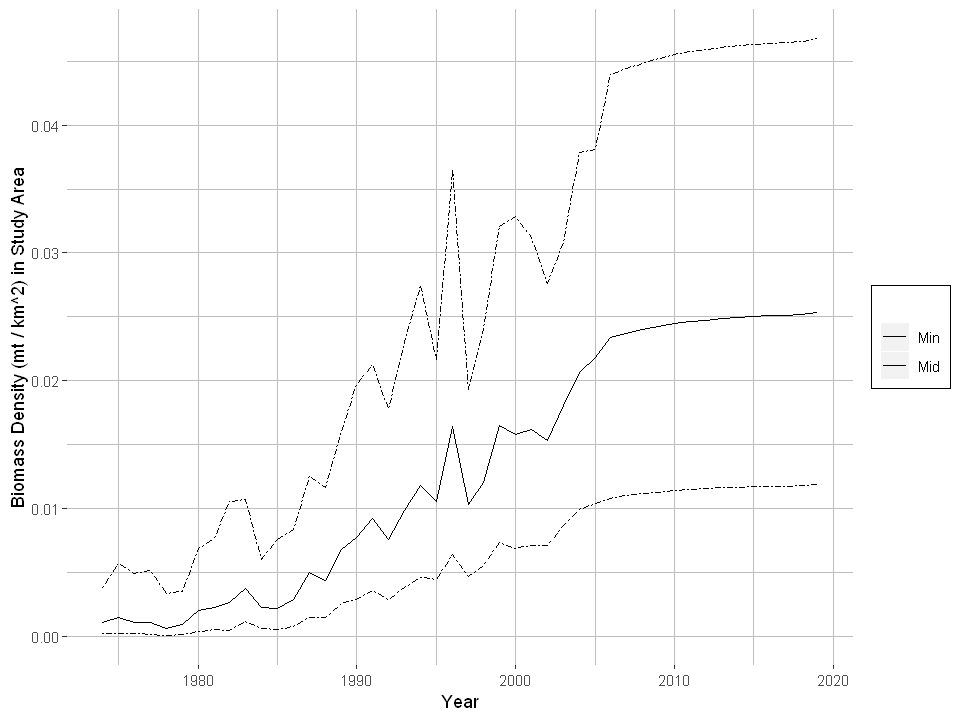

In [105]:
# visualize
library(ggplot2)
options(repr.plot.width=8, repr.plot.height=6)
ggplot(abun_expanded, aes(x=year)) + 
  geom_line(aes(y = total_B_dens_mid, color="darkred")) + 
  geom_line(aes(y = total_B_dens_min, color="steelblue"), linetype="twodash") + 
  geom_line(aes(y = total_B_dens_max, color="steelblue"), linetype="twodash") + 
  scale_color_manual(name = "", 
                       labels = c("Min", "Mid", "Max"), 
                       values= c("black","black","black")) +
  ylab("Biomass Density (mt / km^2) in Study Area") + 
  xlab("Year") + 
  scale_y_continuous(minor_breaks = seq(0.005, 0.055, 0.01), breaks = seq(0 , 0.06, 0.01)) +
  theme(
    panel.background = element_rect(fill = "transparent"), # bg of the panel
    plot.background = element_rect(fill = "transparent", color = NA), # bg of the plot
    panel.grid.major = element_line(colour="grey"), # get rid of major grid
    panel.grid.minor = element_line(colour="grey"), # get rid of minor grid
    legend.background = element_rect(fill = "transparent"), # get rid of legend bg
    legend.box.background = element_rect(fill = "transparent") # get rid of legend panel bg
    )
#as_widget(ggplotly(p, width = 500, height = 200))

In [18]:
 # export time series without full header
options(scipen=500) # suppress scientific notation

trimmed_abun = abun_expanded %>%
select(year,total_B_dens_min,total_B_dens_mid,total_B_dens_max) %>%
rename(TKW_absB_min = total_B_dens_min) %>%
rename(TKW_absB_mid = total_B_dens_mid) %>%
rename(TKW_absB_max = total_B_dens_max) %>%
mutate(across(2:4, round, 5))

write.csv(trimmed_abun,paste(localpath,"TKW_B_timeseries.csv",sep=""),row.names=FALSE)

In [47]:
annual_avg_indiv_mass 

year,avg_TKW_indiv_B_1_min,avg_TKW_indiv_B_2_min,avg_TKW_indiv_B_1_mid,avg_TKW_indiv_B_2_mid,avg_TKW_indiv_B_1_max,avg_TKW_indiv_B_2_max
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
11,0,0,0,0,0,0


In [48]:
temp_avg_indiv_mass

abun..year...i...,avg_TKW_indiv_B_1_min,avg_TKW_indiv_B_2_min,avg_TKW_indiv_B_1_mid,avg_TKW_indiv_B_2_mid,avg_TKW_indiv_B_1_max,avg_TKW_indiv_B_2_max
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1974,3.453796,3.218927,3.453796,3.218927,3.453796,3.218927
